Objectifs 2 : élaborer une grille de score à partir de la régression logistique 
- Préparer une base de train, de validation et de test 
- 60% / 20% / 20% 
- Stratifier les clients dans l’ensemble des échantillons 
- Des techniques d’oversampling ou d’undersampling peuvent être testées (ex 
= SMOTE) dans le cas d’un déséquilibre du jeu de données 
- Transformer les variables catégorielles et les variables numériques 
- Catégorielles : regroupement expert / WOE / taux de risque 
- Numériques : optimisation des tranches via l’indice de GINI ou regroupement 
par expertise 
- Vérifier la valeur d’information avant et après transformation 
- Vérifier la volumétrie des tranches créées (éviter des modalités avec moins de 
5% de la population) 
- Appliquer la méthode d’indicatrice imbriquée avant l’intégration dans le 
modèle 
- Entraîner un modèle de régression logistique  
- Méthode ascendante  
- Ajout des variables ayant un dIV > 0,02 et tester la significativité des 
distributions réelles et estimées 
- Liberté du choix des variables selon vos analyses 
- Vérifié la significativité des coefficients → supprimer ou ajouter en 
conséquence de nouvelles variables 
- Grille de score : 
- Maximum de 6 variables à intégrer 
- Normaliser la grille :  
- Valeur de référence = 500 
- Facteur multiplicatif = 2 
- Nombre de points = 20 
- Ratio de référence = 1 
- Vérifier la monotonie des points attribuées aux modalités des variables et les 
taux de risques 
 
- Performance du modèle : 
- Calculer le GINI du jeu d’entrainement, de validation et du jeu de test 
- Afficher la courbe de concentration associée 
- Créer une table des déciles des tranches de scores  
- Déterminer la tranche maximisant le KS = max|%𝐵𝐴𝐷𝑐𝑢𝑚  − %𝐺𝑂𝑂𝐷𝑐𝑢𝑚| 
- Etudier d’autres métriques dans vos analyses : R2 ajustés, AIC et BIC  
- Calculer l’impact économique de la grille de score et déterminer le seuil de décision :  
- Un client faux positif = pertes de la totalité du crédit financé 
- Un client faux négatif = pertes de 8% (taux d’intérêt des crédits) 
- Choisir la note de score maximisant le gain ou minimisant la perte pour 
déterminer le seuil de décision pour refuser ou accepter un crédit 
- Tracer une courbe de l’équilibre financier en fonction du seuil

In [2]:
pip install imblearn

     |████████████████████████████████| 258 kB 2.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

In [23]:
###############################################################################
# Chargement des données et séparation en train, val et test (60% / 20% / 20%)
#   + Stratification
#   + Définition des variables catégorielles et numériques
###############################################################################
script_dir = os.getcwd()
relative_path = os.path.join(script_dir, '../data/data_cleaned.csv')
df_full = pd.read_csv(relative_path)

target_var = 'GOOD_PAYER'

df_train, df_temp = train_test_split(
    df_full,
    test_size=0.4,
    stratify=df_full[target_var],
    random_state=123
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp[target_var],
    random_state=123
)

categorical_vars = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_CONTRACT_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'
]

quantitative_vars = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'TOTALAREA_MODE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

In [24]:
###############################################################################
# Calcul WoE/IV et transformation des variables catégorielles
###############################################################################
def calculate_woe_iv(data, feature, target):
    """
    Calcule le WoE et l'IV d'une variable catégorielle.
    Retourne (dict: modalité->WoE, IV total).
    """
    cross_tab = pd.crosstab(data[feature], data[target], margins=True)
    cross_tab.columns = ["Bad", "Good", "Total"]
    cross_tab["Distr_Good"] = cross_tab["Good"] / cross_tab.loc[:, "Good"].sum()
    cross_tab["Distr_Bad"] = cross_tab["Bad"] / cross_tab.loc[:, "Bad"].sum()
    
    # Calcul WoE
    cross_tab["WoE"] = np.log(
        (cross_tab["Distr_Good"] / (cross_tab["Distr_Bad"] + 1e-9)) + 1e-9
    )
    cross_tab = cross_tab.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    
    # IV
    cross_tab["IV"] = (cross_tab["Distr_Good"] - cross_tab["Distr_Bad"]) * cross_tab["WoE"]
    
    woe_dict = cross_tab["WoE"].to_dict()
    iv_value = cross_tab["IV"].sum()
    
    return woe_dict, iv_value

def apply_woe(data, feature, woe_dict):
    """
    Applique un dictionnaire WoE à un dataframe pour la colonne "feature".
    Modalités inconnues -> WoE = 0 par défaut.
    """
    return data[feature].map(woe_dict).fillna(0.0)

woe_mappings = {}
ivs_before = {}
ivs_after = {}

# Apprendre la WoE sur le train
for col in categorical_vars:
    woe_dict, iv_val = calculate_woe_iv(df_train, col, target_var)
    woe_mappings[col] = woe_dict
    ivs_before[col] = iv_val
    
    # Créer la colonne transformée sur le train
    df_train[col + "_WoE"] = apply_woe(df_train, col, woe_dict)
    
    # Recalculer l'IV après transformation
    _, iv_val_after = calculate_woe_iv(df_train, col + "_WoE", target_var)
    ivs_after[col] = iv_val_after

# Appliquer la même transformation sur val et test
for col in categorical_vars:
    df_val[col + "_WoE"] = apply_woe(df_val, col, woe_mappings[col])
    df_test[col + "_WoE"] = apply_woe(df_test, col, woe_mappings[col])

# On peut enlever les colonnes catégorielles brutes maintenant
df_train.drop(columns=categorical_vars, inplace=True)
df_val.drop(columns=categorical_vars, inplace=True)
df_test.drop(columns=categorical_vars, inplace=True)

# Afficher les valeurs d'IV avant et après transformation
for col in categorical_vars:
    print(f"IV avant transformation ({col}) = {ivs_before[col]:.4f}")
    print(f"IV après transformation ({col}) = {ivs_after[col]:.4f}")
    print("-" * 40)

IV avant transformation (CODE_GENDER) = 0.0152
IV après transformation (CODE_GENDER) = 0.0152
----------------------------------------
IV avant transformation (FLAG_OWN_CAR) = 0.0073
IV après transformation (FLAG_OWN_CAR) = 0.0073
----------------------------------------
IV avant transformation (FLAG_OWN_REALTY) = 0.0001
IV après transformation (FLAG_OWN_REALTY) = 0.0001
----------------------------------------
IV avant transformation (NAME_INCOME_TYPE) = 0.0149
IV après transformation (NAME_INCOME_TYPE) = 0.0149
----------------------------------------
IV avant transformation (NAME_EDUCATION_TYPE) = 0.0345
IV après transformation (NAME_EDUCATION_TYPE) = 0.0345
----------------------------------------
IV avant transformation (NAME_FAMILY_STATUS) = 0.0089
IV après transformation (NAME_FAMILY_STATUS) = 0.0089
----------------------------------------
IV avant transformation (NAME_CONTRACT_TYPE) = 0.0101
IV après transformation (NAME_CONTRACT_TYPE) = 0.0101
--------------------------------

In [25]:
###############################################################################
# Binning Gini (DecisionTree) pour les variables numériques
###############################################################################
def gini_based_binning(df, feature, target, max_depth=3):
    """
    Crée un arbre de décision pour segmenter 'feature' en fonction de 'target'.
    Renvoie le modèle + les bins sur le df donné.
    """
    dt = DecisionTreeClassifier(
        criterion='gini',
        max_leaf_nodes=max_depth,
        min_samples_leaf=0.05,
        random_state=123
    )
    dt.fit(df[[feature]], df[target])
    bins = dt.apply(df[[feature]])
    return dt, bins

def apply_gini_binning(df, feature, dt):
    return dt.apply(df[[feature]])

# On entraîne un arbre par variable, puis on applique sur train/val/test
tree_models = {}
for var in quantitative_vars:
    dt, train_bins = gini_based_binning(df_train, var, target_var, max_depth=3)
    tree_models[var] = dt
    
    df_train[var + "_bin"] = train_bins
    df_val[var + "_bin"]   = apply_gini_binning(df_val, var, dt)
    df_test[var + "_bin"]  = apply_gini_binning(df_test, var, dt)

In [26]:
###############################################################################
# Vérifier la volumétrie des tranches (<5%) et fusionner les bins trop petits
###############################################################################
def merge_small_bins_train(df_train, feature_bin, min_percent=0.05):
    """
    Fusionne les bins trop petits (proportion < min_percent) UNIQUEMENT sur df_train.
    Retourne un mapping {old_bin -> new_bin} pour application à val/test.
    """
    col_data = df_train[feature_bin].copy()
    unique_bins = sorted(col_data.unique())
    bin_mapping = {b: b for b in unique_bins}  # mapping initial

    counts = col_data.value_counts(normalize=True).sort_index()
    while True:
        small_bins = counts[counts < min_percent]
        if small_bins.empty:
            break

        bin_to_merge = small_bins.index[0]
        if bin_to_merge == counts.index.min(): 
            # Fusionne avec le bin supérieur (cas de la borne inférieure)
            idx = counts.index.tolist().index(bin_to_merge)
            next_bin = counts.index[idx + 1]
            col_data.loc[col_data == bin_to_merge] = next_bin
            for k, v in bin_mapping.items():
                if v == bin_to_merge:
                    bin_mapping[k] = next_bin
        else:
            # Fusionne avec le bin inférieur
            idx_bin = counts.index.tolist().index(bin_to_merge)
            prev_bin = counts.index[idx_bin - 1]
            col_data.loc[col_data == bin_to_merge] = prev_bin
            for k, v in bin_mapping.items():
                if v == bin_to_merge:
                    bin_mapping[k] = prev_bin

        counts = col_data.value_counts(normalize=True).sort_index()

    # Met à jour df_train
    df_train[feature_bin] = col_data

    # "Nettoyage" final du mapping (chaînage)
    final_mapping = {}
    for b in bin_mapping:
        new_b = bin_mapping[b]
        while new_b in bin_mapping and bin_mapping[new_b] != new_b:
            new_b = bin_mapping[new_b]
        final_mapping[b] = new_b

    return final_mapping

In [27]:
###############################################################################
# Vérifier la monotonie des taux de risque dans les bins et fusionner si violée
###############################################################################
def is_monotonic(df, feature_bin, target):
    grouped = df.groupby(feature_bin)[target].mean().sort_index()
    diffs = grouped.diff().fillna(0)
    incr = (diffs >= 0).all()
    decr = (diffs <= 0).all()
    return (incr or decr)

def force_monotonic_bins_train(df_train, feature_bin, target):
    """
    Force la monotonie des bins UNIQUEMENT sur df_train, et retourne un mapping.
    Si la monotonie est violée, on fusionne le bin provoquant l'inversion
    dans le bin précédent (exemple très simplifié).
    """
    col_data = df_train[feature_bin].copy()
    unique_bins = sorted(col_data.unique())
    bin_mapping = {b: b for b in unique_bins}  # mapping initial

    while not is_monotonic(df_train, feature_bin, target):
        grouped = df_train.groupby(feature_bin)[target].mean().sort_index()
        diffs = grouped.diff().fillna(0)
        sign_changes = diffs * diffs.shift(-1)
        idx_to_merge = sign_changes.idxmin()  # bin où se produit l'inversion max

        unique_bins = sorted(col_data.unique())
        if idx_to_merge in unique_bins:
            pos = unique_bins.index(idx_to_merge)
            if pos > 0:
                merge_target = unique_bins[pos-1]
                col_data.loc[col_data == idx_to_merge] = merge_target
                # Mettre à jour le mapping
                for k, v in bin_mapping.items():
                    if v == idx_to_merge:
                        bin_mapping[k] = merge_target
            else:
                break
        else:
            break

        df_train[feature_bin] = col_data  # mise à jour pour la prochaine boucle

    # Nettoyage final du mapping (chaînage)
    final_mapping = {}
    for b in bin_mapping:
        new_b = bin_mapping[b]
        while new_b in bin_mapping and bin_mapping[new_b] != new_b:
            new_b = bin_mapping[new_b]
        final_mapping[b] = new_b

    return final_mapping

In [28]:
# Fonction pour appliquer le mapping à df_val / df_test
def apply_bin_mapping(df, feature_bin, bin_mapping):
    """
    Applique le mapping bin_mapping {old_bin -> new_bin} à df[feature_bin].
    """
    for old_bin, new_bin in bin_mapping.items():
        df.loc[df[feature_bin] == old_bin, feature_bin] = new_bin

for var in quantitative_vars:
    bin_col = var + "_bin"
    if bin_col in df_train.columns:
        # On fusionne les bins trop petits
        mapping_small = merge_small_bins_train(df_train, bin_col, min_percent=0.05)
        # On applique ce mapping à val et test
        if bin_col in df_val.columns:
            apply_bin_mapping(df_val, bin_col, mapping_small)
        if bin_col in df_test.columns:
            apply_bin_mapping(df_test, bin_col, mapping_small)
        
        # Forcer la monotonie sur le train
        mapping_mono = force_monotonic_bins_train(df_train, bin_col, target_var)
        # Appliquer la même logique à val/test
        if bin_col in df_val.columns:
            apply_bin_mapping(df_val, bin_col, mapping_mono)
        if bin_col in df_test.columns:
            apply_bin_mapping(df_test, bin_col, mapping_mono)

In [29]:
###############################################################################
# Méthode d’indicatrice imbriquée
###############################################################################
def make_indicators(df, bin_col):
    return pd.get_dummies(df[bin_col], prefix=bin_col, drop_first=False)

for var in quantitative_vars:
    bin_col = var+"_bin"
    # Création des indicatrices pour ce bin
    dummies = make_indicators(df_train, bin_col)
    # On concatène ces nouvelles colonnes au dataframe
    df_train = pd.concat([df_train, dummies], axis=1)

    # Faire la même chose sur df_val et df_test
    dummies_val = make_indicators(df_val, bin_col)
    df_val = pd.concat([df_val, dummies_val], axis=1)
    
    dummies_test = make_indicators(df_test, bin_col)
    df_test = pd.concat([df_test, dummies_test], axis=1)

In [30]:
###############################################################################
# Sélection des variables par IV (> 0.02) pour la partie WoE + toutes bin
###############################################################################
selected_cat_features = [c+"_WoE" for c in woe_mappings.keys() if ivs[c] > 0.02]
selected_num_features = [v+"_bin" for v in quantitative_vars]

prelim_features = selected_cat_features + selected_num_features
prelim_features = [f for f in prelim_features if f in df_train.columns]

X_train = df_train[prelim_features]
y_train = df_train[target_var]

X_val = df_val[prelim_features]
y_val = df_val[target_var]

X_test = df_test[prelim_features]
y_test = df_test[target_var]

In [31]:
###############################################################################
# Entraîner un modèle de régression logistique
#   - Méthode ascendante pour limiter à 6 variables
###############################################################################
def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.Logit(y, sm.add_constant(X[best_features + [new_column]])).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
            if len(best_features) == 6:  # limite à 6
                break
        else:
            break
    return best_features

selected_features = forward_selection(X_train, y_train)
print("Variables sélectionnées par la méthode ascendante (sans oversampling):")
print(selected_features)

# Oversampling SMOTE après la sélection
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train[selected_features], y_train)

# Régression logistique finale sur X_train_res
model_final = LogisticRegression(max_iter=1000, random_state=123)
model_final.fit(X_train_res, y_train_res)

<ipython-input-31-6f93ba580592>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Variables sélectionnées par la méthode ascendante (sans oversampling):
['EXT_SOURCE_3_bin', 'EXT_SOURCE_2_bin', 'OCCUPATION_TYPE_WoE', 'DAYS_EMPLOYED_bin', 'NAME_EDUCATION_TYPE_WoE', 'AMT_CREDIT_bin']


LogisticRegression(max_iter=1000, random_state=123)

In [32]:
###############################################################################
# Performance du modèle : ROC AUC, Gini, KS
###############################################################################
y_train_pred_proba = model_final.predict_proba(X_train_res)[:, 1]
roc_train = roc_auc_score(y_train_res, y_train_pred_proba)
gini_train = 2*roc_train - 1

y_val_pred_proba = model_final.predict_proba(X_val[selected_features])[:, 1]
roc_val = roc_auc_score(y_val, y_val_pred_proba)
gini_val = 2*roc_val - 1

y_test_pred_proba = model_final.predict_proba(X_test[selected_features])[:, 1]
roc_test = roc_auc_score(y_test, y_test_pred_proba)
gini_test = 2*roc_test - 1

print(f"\nROC AUC (train_res): {roc_train:.4f}, Gini(train_res): {gini_train:.4f}")
print(f"ROC AUC (val)      : {roc_val:.4f},   Gini(val)       : {gini_val:.4f}")
print(f"ROC AUC (test)     : {roc_test:.4f},  Gini(test)      : {gini_test:.4f}")

fpr_val, tpr_val, thr_val = roc_curve(y_val, y_val_pred_proba)
ks_val = max(tpr_val - fpr_val)
fpr_test, tpr_test, thr_test = roc_curve(y_test, y_test_pred_proba)
ks_test = max(tpr_test - fpr_test)
print(f"KS (val)  : {ks_val:.4f}")
print(f"KS (test) : {ks_test:.4f}")

# Vérifier la distribution finale dans df_val / df_test
print("\nDistribution de la cible dans df_val:", y_val.value_counts(normalize=True))
print("Distribution de la cible dans df_test:", y_test.value_counts(normalize=True))


ROC AUC (train_res): 0.6966, Gini(train_res): 0.3931
ROC AUC (val)      : 0.6894,   Gini(val)       : 0.3789
ROC AUC (test)     : 0.6894,  Gini(test)      : 0.3788
KS (val)  : 0.2864
KS (test) : 0.2898

Distribution de la cible dans df_val: 1    0.9134
0    0.0866
Name: GOOD_PAYER, dtype: float64
Distribution de la cible dans df_test: 1    0.913401
0    0.086599
Name: GOOD_PAYER, dtype: float64


In [33]:
###############################################################################
# Table des déciles sur validation
###############################################################################
df_val_score = pd.DataFrame({
    'y_true': y_val,
    'proba': y_val_pred_proba
})
df_val_score['decile'] = pd.qcut(df_val_score['proba'], 10, labels=False, duplicates='drop')
decile_summary = df_val_score.groupby('decile').agg({
    'y_true': ['count','sum','mean'],
    'proba': ['min','max','mean']
})
decile_summary.columns = ['_'.join(col) for col in decile_summary.columns]
decile_summary = decile_summary.sort_index(ascending=False)
print("\n== Table des déciles (Validation) ==\n", decile_summary)


== Table des déciles (Validation) ==
         y_true_count  y_true_sum  y_true_mean  proba_min  proba_max  \
decile                                                                
9               5036        4921     0.977164   0.748540   0.932758   
8               4822        4651     0.964538   0.701784   0.748296   
7               5201        4982     0.957893   0.639567   0.701660   
6               5108        4847     0.948904   0.603146   0.639550   
5               4922        4588     0.932141   0.556026   0.602944   
4               4799        4453     0.927902   0.514335   0.555997   
3               4758        4300     0.903741   0.470749   0.514169   
2               5695        5004     0.878665   0.407532   0.470719   
1               4630        3955     0.854212   0.311989   0.407165   
0               5456        4359     0.798937   0.102341   0.311963   

        proba_mean  
decile              
9         0.799486  
8         0.722299  
7         0.673815  
6  

In [34]:
###############################################################################
# Statsmodels sur le modèle final
###############################################################################
df_train_sm = pd.concat([
    pd.DataFrame(X_train_res, columns=selected_features),
    pd.Series(y_train_res, name=target_var)
], axis=1)

formula = f"{target_var} ~ " + " + ".join(selected_features)
logit_model = sm.Logit.from_formula(formula, data=df_train_sm).fit(disp=0)

print("\n== Statsmodels (Logit) sur échantillon train_res ==")
print(logit_model.summary())
print(f"AIC : {logit_model.aic:.2f}")
print(f"BIC : {logit_model.bic:.2f}")
print(f"Pseudo-R² (McFadden) : {logit_model.prsquared:.4f}")


== Statsmodels (Logit) sur échantillon train_res ==
                           Logit Regression Results                           
Dep. Variable:             GOOD_PAYER   No. Observations:               276362
Model:                          Logit   Df Residuals:                   276355
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                 0.08731
Time:                        18:22:27   Log-Likelihood:            -1.7483e+05
converged:                       True   LL-Null:                   -1.9156e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.4610      0.024    -19.379      0.000      -0.508      -0.414
EXT_SOURCE_3_bin            0.4564     


Seuil minimisant la perte sur Validation = 0.52


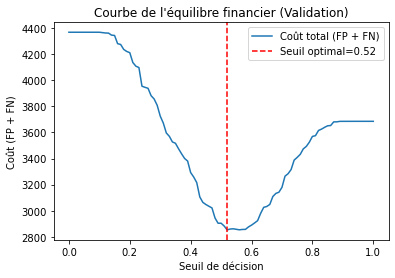

In [35]:
###############################################################################
# Impact économique & seuil optimal
###############################################################################
def economic_impact(y_true, y_proba, threshold):
    fp_cost = 1.0
    fn_cost = 0.08
    y_pred = (y_proba >= threshold).astype(int)
    fp = ((y_pred == 1) & (y_true == 0)).sum() * fp_cost
    fn = ((y_pred == 0) & (y_true == 1)).sum() * fn_cost
    return fp + fn

thresholds = np.linspace(0,1,101)
costs = [economic_impact(df_val_score['y_true'], df_val_score['proba'], thr) for thr in thresholds]
optimal_thr = thresholds[np.argmin(costs)]
print(f"\nSeuil minimisant la perte sur Validation = {optimal_thr:.2f}")

plt.figure(figsize=(6,4))
plt.plot(thresholds, costs, label="Coût total (FP + FN)")
plt.axvline(optimal_thr, color='red', linestyle='--', label=f"Seuil optimal={optimal_thr:.2f}")
plt.title("Courbe de l'équilibre financier (Validation)")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût (FP + FN)")
plt.legend()
plt.show()

In [36]:
###############################################################################
# Grille de score normalisée
###############################################################################
def compute_score(prob, offset=500, factor=2):
    odds = np.clip(prob / (1 - prob + 1e-9), 1e-9, None)
    return offset + factor * np.log(odds)

df_val_score['score_final'] = compute_score(df_val_score['proba'], offset=500, factor=2)
print("\nAperçu du score final (Val) :")
print(df_val_score[['proba','score_final']].head(10))


Aperçu du score final (Val) :
           proba  score_final
64387   0.839736   503.312535
212657  0.617143   500.954878
128930  0.726551   501.954386
148421  0.735767   502.048160
166836  0.178039   496.940620
50687   0.630307   501.067067
63699   0.470452   499.763337
239295  0.583968   500.678166
187811  0.628228   501.049248
205694  0.630307   501.067067


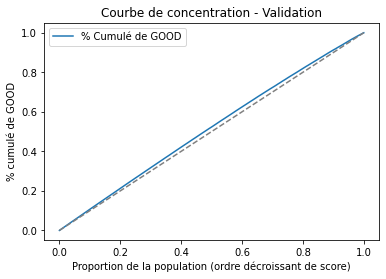

In [37]:
###############################################################################
# Courbe de concentration
###############################################################################
def plot_concentration_curve(y_true, y_score, title="Courbe de concentration"):
    data = pd.DataFrame({'y_true': y_true, 'score': y_score})
    data = data.sort_values('score', ascending=False)
    cumsum_good = (data['y_true'] == 1).cumsum()
    total_good = (data['y_true'] == 1).sum()
    pct_good_cum = cumsum_good / total_good
    n = len(data)
    x = np.arange(1, n+1) / n
    
    plt.figure(figsize=(6,4))
    plt.plot(x, pct_good_cum, label="% Cumulé de GOOD")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(title)
    plt.xlabel("Proportion de la population (ordre décroissant de score)")
    plt.ylabel("% cumulé de GOOD")
    plt.legend()
    plt.show()

plot_concentration_curve(df_val_score['y_true'], df_val_score['proba'], title="Courbe de concentration - Validation")